In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
import tensorflow as tf
import numpy as np
from gpflow.models import GPModel, SVGP
from gpflow.base import Parameter
from gpflow.models.training_mixins import ExternalDataTrainingLossMixin
from gpflow.mean_functions import MeanFunction
from gpflow import posteriors
from gpflow.kullback_leiblers import gauss_kl
from gpflow.config import default_jitter, default_float
from gpflow.utilities import positive, triangular
from gpflow.models.util import inducingpoint_wrapper
from gpflow.conditionals.util import sample_mvn
from gpflow.quadrature import NDiagGHQuadrature
# from gparkme.posteriors import create_posterior
from typing import Optional


class GPCDE(SVGP):
    def __init__(
        self,
        kernel,
        likelihood,
        inducing_variable,
        mean_function: Optional[MeanFunction] = None,
        num_quadrature: int = 10,
        q_diag: bool = False,
        whiten: bool = True,
        q_mu=None,
        q_sqrt=None,
        num_latent_gps=1
    ):
        super().__init__(
            kernel,
            likelihood,
            mean_function=mean_function,
            num_latent_gps=num_latent_gps,
            q_diag=q_diag,
            whiten=whiten,
            inducing_variable=inducing_variable,
            q_mu=q_mu,
            q_sqrt=q_sqrt,
        )
        self.num_quadrature = num_quadrature

    def _init_quadrature(self, X, Y, num_minibatch = 100):
        self.num_data= X.shape[0]
        self.num_dim = X.shape[1]
        self.num_minibatch = num_minibatch
        self.quadrature = NDiagGHQuadrature(1, self.num_quadrature)
        quadrature_locs, quadrature_weights = self.quadrature._build_X_W(np.zeros(1), np.ones(1))
        self.quadrature_weights = quadrature_weights[:,0]
        self.quadrature_weights = self.quadrature_weights[None, :]
        quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
        quadrature_locs = tf.tile(quadrature_locs, multiples=[X.shape[0],1,1])
        X = X[:,None,:]
        Y = Y[:,None,:]
        X = tf.tile(X, multiples=[1, self.num_quadrature, 1])
        Y = tf.tile(Y, multiples=[1, self.num_quadrature, 1])
        X = tf.concat([X, quadrature_locs],axis=-1)
        ds = tf.data.Dataset.from_tensor_slices((X, Y))
        ds_iter = iter(ds.repeat().shuffle(self.num_data).batch(num_minibatch))
        return ds_iter

    def predict_f_samples(
        self,
        Xnew,
        obs_noise=False,
        num_samples: Optional[int] = None,
        full_cov: bool = False,
        full_output_cov: bool = False,
    ) -> tf.Tensor:
        """
        Produce samples from the posterior latent function(s) at the input points.
        :param Xnew: InputData
            Input locations at which to draw samples, shape [..., N, D]
            where N is the number of rows and D is the input dimension of each point.
        :param num_samples:
            Number of samples to draw.
            If `None`, a single sample is drawn and the return shape is [..., N, P],
            for any positive integer the return shape contains an extra batch
            dimension, [..., S, N, P], with S = num_samples and P is the number of outputs.
        :param full_cov:
            If True, draw correlated samples over the inputs. Computes the Cholesky over the
            dense covariance matrix of size [num_data, num_data].
            If False, draw samples that are uncorrelated over the inputs.
        :param full_output_cov:
            If True, draw correlated samples over the outputs.
            If False, draw samples that are uncorrelated over the outputs.
        Currently, the method does not support `full_output_cov=True` and `full_cov=True`.
        """
        if full_cov and full_output_cov:
            raise NotImplementedError(
                "The combination of both `full_cov` and `full_output_cov` is not supported."
            )

        # check below for shape info
        mean, cov = self.predict_f(Xnew, full_cov=full_cov, full_output_cov=full_output_cov)
        if obs_noise is True and full_cov is False:
            cov += self.likelihood.variance
        if full_cov:
            # mean: [..., N, P]
            # cov: [..., P, N, N]
            mean_for_sample = tf.linalg.adjoint(mean)  # [..., P, N]
            samples = sample_mvn(
                mean_for_sample, cov, full_cov, num_samples=num_samples
            )  # [..., (S), P, N]
            samples = tf.linalg.adjoint(samples)  # [..., (S), N, P]
        else:
            # mean: [..., N, P]
            # cov: [..., N, P] or [..., N, P, P]
            samples = sample_mvn(
                mean, cov, full_output_cov, num_samples=num_samples
            )  # [..., (S), N, P]
        return samples  # [..., (S), N, P]

    def predict_full_samples_layer(self, Xnew, obs_noise=False, num_latent_samples=50, num_gp_samples=50):
        w = np.random.normal(size=(num_latent_samples, Xnew.shape[0], 1))
        sampling_func = lambda x: self.predict_f_samples(x, obs_noise=obs_noise, num_samples=num_gp_samples)

        def sample_latent_gp(w_single):
            X = np.concatenate([Xnew, w_single], axis=1)
            samples = sampling_func(X)
            return samples

        samples = tf.map_fn(sample_latent_gp, w)

        return samples

    def predict_credible_layer(
        self,
        Xnew,
        lower_quantile=2.5,
        upper_quantile=97.5,
        num_gp_samples=50,
        num_latent_samples=50,
        obs_noise=False,
    ):

        samples = self.predict_full_samples_layer(
            Xnew,
            obs_noise=obs_noise,
            num_gp_samples=num_gp_samples,
            num_latent_samples=num_latent_samples,
        )
        lower = np.percentile(samples, lower_quantile, axis=[0,1])
        median = np.percentile(samples, 50, axis=[0,1])
        upper = np.percentile(samples, upper_quantile, axis=[0,1])

        return lower, median, upper, samples


    def maximum_log_likelihood_objective(self, data) -> tf.Tensor:
        return self.elbo(data)

    def elbo(self, data) -> tf.Tensor:
        """
        This gives a variational bound (the evidence lower bound or ELBO) on
        the log marginal likelihood of the model.
        """
        X, Y = data
        X = tf.reshape(X, (self.num_minibatch*self.num_quadrature, self.num_dim+1))
        Y = tf.reshape(Y, (self.num_minibatch*self.num_quadrature, 1))
        kl = self.prior_kl()
        f_mean, f_var = self.predict_f(X)
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
        # each var_exp is (num_minibatch, num_quadrature, 1)
        var_exp = tf.reshape(var_exp, (self.num_minibatch, self.num_quadrature))
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)

        # var_exp = tf.reduce_sum(var_exp, axis=0) * scale
        quadrature_weights = self.quadrature_weights
        term1 = tf.math.reduce_logsumexp(var_exp + tf.math.log(quadrature_weights),axis=1)
        return tf.reduce_sum(term1) * scale - kl


In [4]:
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt


def run_optimizer(model, ds_iter, iterations):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(ds_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)
    iterator = trange(iterations) 
    for step in iterator:
        optimization_step()
        if step % 1000 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
            iterator.set_description(f"EPOCH: {step}, ELBO: {elbo}")


            obs_new = np.linspace(-5, 5, 3000)[:, None]

            lower, median, upper, samples = model.predict_credible_layer(
                Xnew=obs_new,
                obs_noise=True
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, median, c='b', alpha=0.2)
            # plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
            plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
            plt.show()
            plt.close()
            
    return logf

In [5]:
from sklearn.preprocessing import StandardScaler

# Get data
X = np.random.randn(2000, 1)
Y = (X ** 5)   + (np.random.randn(2000, 1))
N = X.shape[0]
num_minibatch = 100


X = StandardScaler().fit_transform(X).astype(np.float64)
Y = StandardScaler().fit_transform(Y).astype(np.float64)

In [6]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.003, 0.1]
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
# kernel_1.variance.assign(kernl_var)
kernel_2 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.concatenate(
        [
            np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            # X[:M, :].copy(),
            np.random.randn(M, 1),
        ],
        axis=1
    )
model = GPCDE(
    kernel=kernel,
    likelihood=gpflow.likelihoods.Gaussian(
        variance=1e-5
        # variance=m.likelihood.variance.numpy(),
    ),
    inducing_variable=Z,
    num_quadrature=10,
    whiten=True
)
ds_iter = model._init_quadrature(X=X, Y=Y, num_minibatch=num_minibatch)

2022-09-09 16:06:46.369706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:06:46.385062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:06:46.385162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:06:46.385763: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-09-09 16:06:47.818690: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
EPOCH: 0, ELBO: -12280110.989037579:   0%|          | 0/30000 [00:04<?, ?it/s]

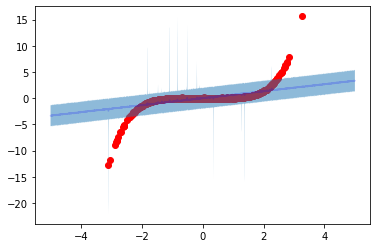

EPOCH: 1000, ELBO: -17593.49517671307:   3%|▎         | 1000/30000 [00:16<04:45, 101.72it/s]

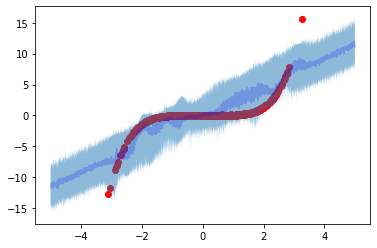

EPOCH: 2000, ELBO: -5675.80834877104:   7%|▋         | 2000/30000 [00:28<04:37, 101.08it/s] 

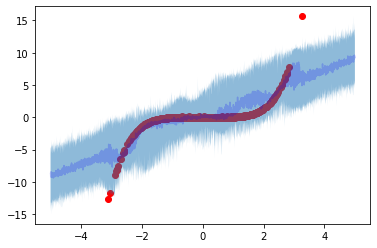

EPOCH: 3000, ELBO: -3287.7567265918624:  10%|▉         | 2999/30000 [00:40<04:25, 101.75it/s]

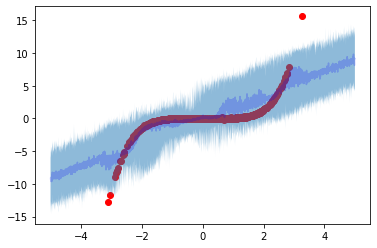

EPOCH: 4000, ELBO: -3839.167070980837:  13%|█▎        | 3997/30000 [00:52<04:16, 101.47it/s] 

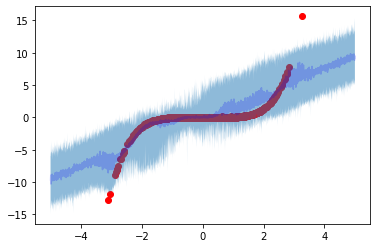

EPOCH: 5000, ELBO: -18729.75732483446:  17%|█▋        | 4997/30000 [01:04<04:07, 101.20it/s]

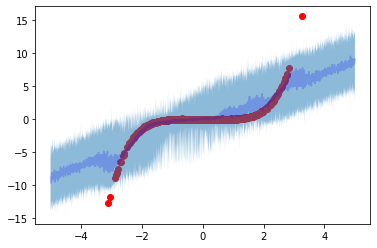

EPOCH: 6000, ELBO: -2241.6374335915607:  20%|█▉        | 5997/30000 [01:16<03:55, 101.90it/s]

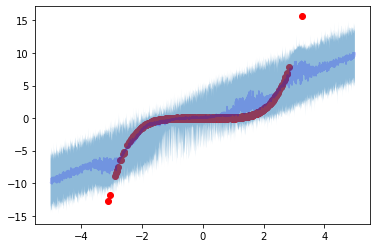

EPOCH: 7000, ELBO: -1710.3592659905025:  23%|██▎       | 6995/30000 [01:28<03:46, 101.40it/s]

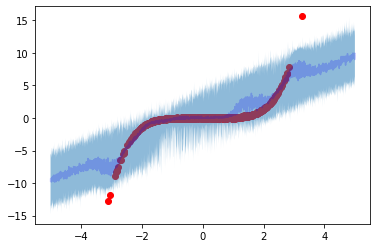

EPOCH: 8000, ELBO: -843.8321156319654:  27%|██▋       | 7995/30000 [01:40<03:36, 101.59it/s] 

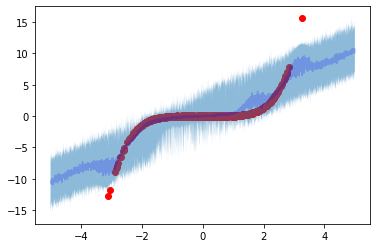

EPOCH: 9000, ELBO: -974.6532313777593:  30%|██▉       | 8995/30000 [01:52<03:26, 101.54it/s]

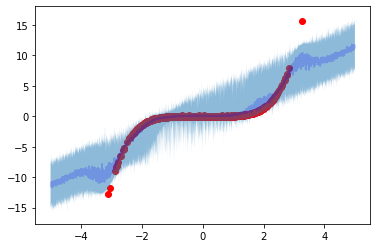

EPOCH: 10000, ELBO: -606.681198556478:  33%|███▎      | 9993/30000 [02:04<03:16, 101.74it/s]

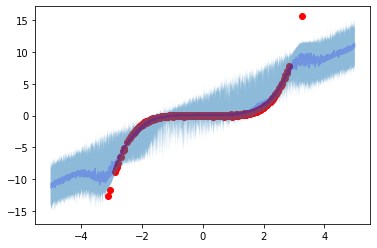

EPOCH: 11000, ELBO: -351.9165584726944:  37%|███▋      | 10992/30000 [02:16<03:07, 101.14it/s]

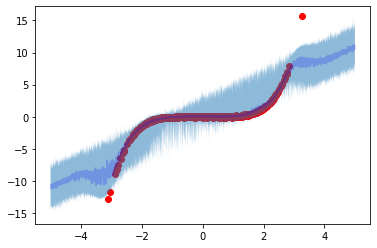

EPOCH: 12000, ELBO: -640.2863755094409:  40%|███▉      | 11991/30000 [02:29<02:56, 102.02it/s]

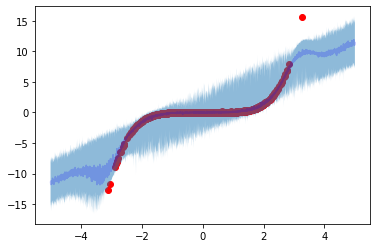

EPOCH: 13000, ELBO: -242.16548511850232:  43%|████▎     | 13000/30000 [02:41<02:47, 101.63it/s]

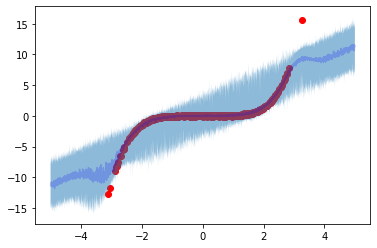

EPOCH: 14000, ELBO: -280.00767301547444:  47%|████▋     | 14000/30000 [02:53<02:37, 101.65it/s]

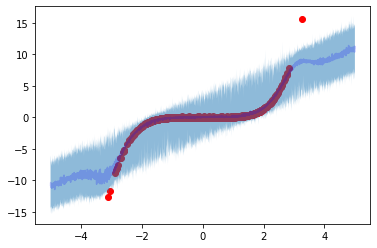

EPOCH: 15000, ELBO: -115.69112438658277:  50%|████▉     | 14999/30000 [03:05<02:28, 100.80it/s]

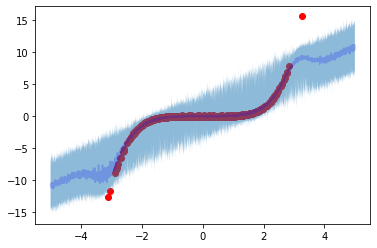

EPOCH: 16000, ELBO: 11.661211591666273:  53%|█████▎    | 15998/30000 [03:17<02:18, 101.17it/s] 

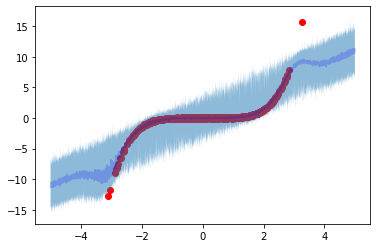

EPOCH: 17000, ELBO: 82.02536668906791:  57%|█████▋    | 16998/30000 [03:29<02:07, 101.59it/s] 

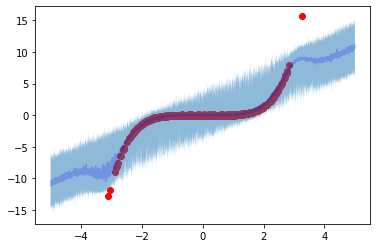

EPOCH: 18000, ELBO: 58.50035674195402:  60%|█████▉    | 17997/30000 [03:41<01:57, 101.78it/s]

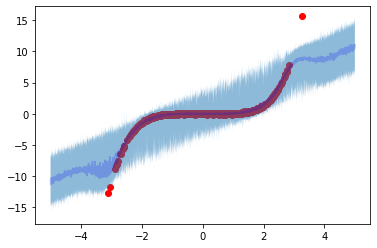

EPOCH: 19000, ELBO: 102.11349808329723:  63%|██████▎   | 18996/30000 [03:53<01:48, 101.52it/s]

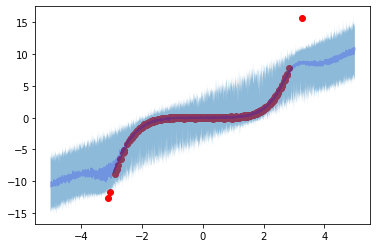

EPOCH: 20000, ELBO: 88.62872907987628:  67%|██████▋   | 19995/30000 [04:05<01:38, 102.08it/s] 

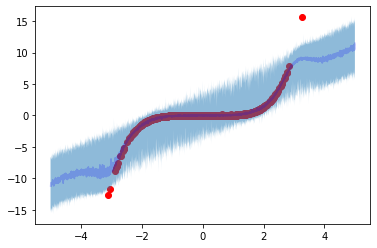

EPOCH: 21000, ELBO: 109.6800417984143:  70%|██████▉   | 20994/30000 [04:17<01:29, 100.99it/s]

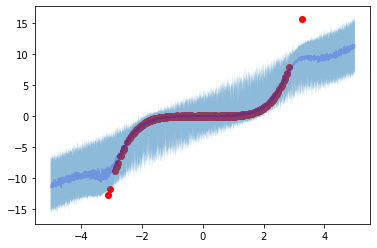

EPOCH: 22000, ELBO: 118.0764934824194:  73%|███████▎  | 21991/30000 [04:29<01:18, 101.84it/s]

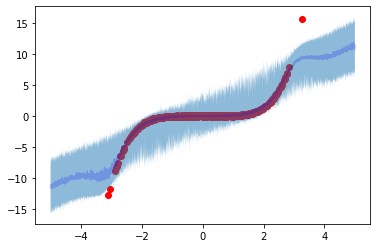

EPOCH: 23000, ELBO: 96.00314104455008:  77%|███████▋  | 22996/30000 [04:41<01:09, 101.26it/s]

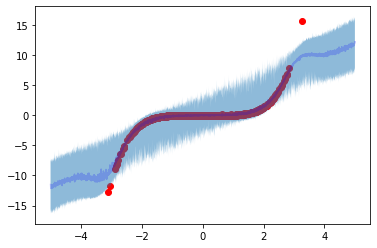

EPOCH: 24000, ELBO: 111.29319187806452:  80%|███████▉  | 23995/30000 [04:53<00:59, 101.41it/s]

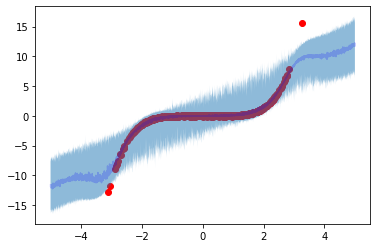

EPOCH: 25000, ELBO: 105.71247637079765:  83%|████████▎ | 24995/30000 [05:05<00:49, 101.86it/s]

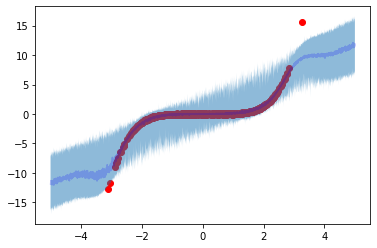

EPOCH: 26000, ELBO: 130.19373126305715:  87%|████████▋ | 25994/30000 [05:18<00:39, 101.07it/s]

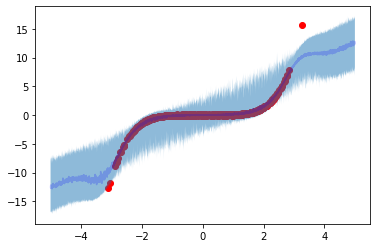

EPOCH: 27000, ELBO: 83.83561904116884:  90%|████████▉ | 26990/30000 [05:30<00:29, 101.06it/s] 

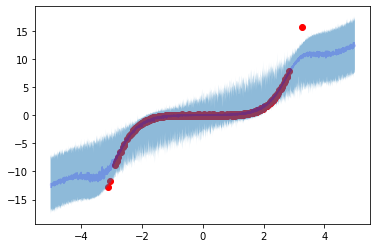

EPOCH: 28000, ELBO: 121.71443527391979:  93%|█████████▎| 27990/30000 [05:42<00:19, 101.33it/s]

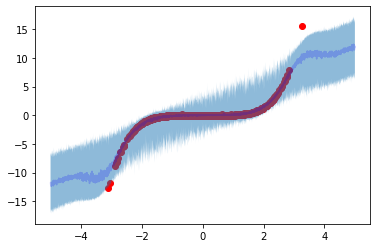

EPOCH: 29000, ELBO: 131.07048805253496:  97%|█████████▋| 28999/30000 [05:54<00:09, 100.86it/s]

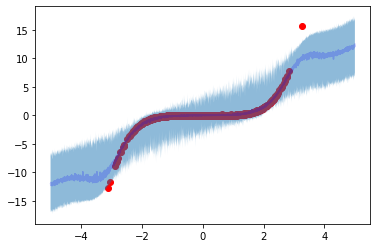

EPOCH: 29000, ELBO: 131.07048805253496: 100%|██████████| 30000/30000 [06:06<00:00, 81.89it/s] 


In [7]:
_ = run_optimizer(
    model=model,
    ds_iter=ds_iter,
    iterations=30000
)

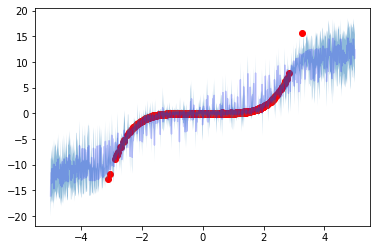

In [8]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], 1])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()


In [10]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.003]
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
# kernel_1.variance.assign(kernl_var)
kernel_2 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.linspace(X.min(), X.max(), M).reshape(-1, 1)
model =  gpflow.models.SVGP(
    kernel, gpflow.likelihoods.Gaussian(variance=1e-5), Z, num_data=N)


In [11]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)


In [12]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [13]:
_ = run_adam(
    model, 
    iterations=30000
)

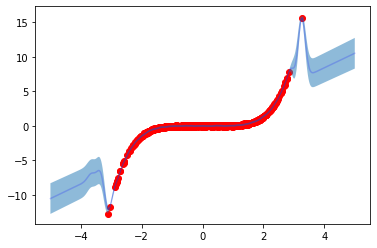

In [14]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = obs_new
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()